# Projet AI28

In [3]:
# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew

# MATPLOTLIB
import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN
import seaborn as sns


# SCIKIT-LEARN: SELECTION DE VARIABLES

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection  import f_classif # test d'ANOVA

# SCIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 

from sklearn.decomposition import PCA
from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap, TSNE
from sklearn.metrics import PrecisionRecallDisplay

# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression # Régression logistique
##SVM
from sklearn.svm import LinearSVC, SVC # Machines à vecteurs de support
## SGD
from sklearn.linear_model import SGDClassifier #  Classifieur (SVM, régression logistique, etc.) avec un algorithme SGD

## ARBRES, FORETS, APRRENTISSAGE D'ENSEMBLE
from sklearn.tree import DecisionTreeClassifier # Arbres de décision (classification)
from sklearn.ensemble import RandomForestClassifier # Forêts aléatoires (classification)
from sklearn.ensemble import BaggingClassifier # Classifier Bagging (classification)
from sklearn.ensemble import AdaBoostClassifier # Classifier Adaboost (classification)
from sklearn.ensemble import GradientBoostingClassifier  # Gradient de boosting (classification)

## KNN
from sklearn.neighbors import KNeighborsClassifier # KPP voisins


# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparation des données en train et test set
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visulaisr les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # tester plusieurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV # tester arbitrairement plusieurs hyperparamètres
from sklearn.model_selection import learning_curve # courbe d'apprentissage: visualisation les scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION
from sklearn.metrics import accuracy_score # Exactitude (accuracy)
from sklearn.metrics import f1_score # F1-score
from sklearn.metrics import confusion_matrix # Matrice de confusion
from sklearn.metrics import plot_confusion_matrix # Graphique de la matrice de confusion
from sklearn.metrics import classification_report # Rapport pour le modèle de classification

## EVALUATION: COURBE ROC
from sklearn.metrics import auc # Aire sous la courbe 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import precision_recall_curve, average_precision_score #
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import PrecisionRecallDisplay

# SCHIKIT-LEARN: PIPELINE et TRANSFORMATEUR
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# OS
import os, sys

RANDOM_STATE = 0 #fixed random state from the beginning

### Contexte
 Prédiction d’une souscription à un contrat de dépôt bancaire à terme

Le jeu de données est lié aux campagnes de marketing d’une institution bancaire portugaise, la compagne marketing est basée sur des appels téléphoniques avec des clients, à la fin de cet appel est décidé si le client souscrira un dépôt bancaire à terme (classe oui) ou pas (classe non).
Analyser le jeu de données fourni avec ce projet et identifier les modèles qui vous aiderez à tirer des conclusions afin de développer des stratégies futures. 
Dètails: https://archive.ics.uci.edu/ml/datasets/Bank+Marketin

In [244]:
class dataset():
    def __init__(self, datasetFileName, target):
        '''
        Dataset class constructor
        @Params
        datasetFilename: String with the dataset file name (not path)
        target: String - target variable to predict
        '''
        self.df = self.loadDataset(datasetFileName).copy()
        self.target = target
        self.n_samples, self.n_features = self.df.shape
        self.missrates = self.df.isna().sum() / len(self.df) #numpy array of missing values pourcentages
        self.catFeatures, self.contFeatures = self.initFeatures()
        #Separate Test and train set after feature cleaning (not necessary feature selection)
        #df creation executed in the preprocessing
        self.df_train = None
        self.df_test = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test =None
        
    def loadDataset(self, fileName):
        '''
        create the pandas dataframe object
        @Params
        filename: String with the dataset file name (not path)
        @Returns:
        _REP_DATASET_: pandas dataframe object with loaded data
        '''
        # SYSTEME D'EXPLOITATION / CHARGEMENT DE DONNEES
        _REP_DATA_ = 'data' # chemin d'accès au dataset
        _REP_DATA_PATH_ = os.path.join(_REP_DATA_, fileName)
        # afficher le répertoire du dataset
        print("Répertoire du dataset train:", _REP_DATA_PATH_)
        #chargement des données avec pandas
        _REP_DATASET_ = pd.read_csv(_REP_DATA_PATH_, delimiter=";")
        return _REP_DATASET_

    def overview(self):
        '''
        prints a quick overview of the dataframe object current state
        '''
        print("Nombre de lignes (samples): %s" %self.n_samples)
        print("Nombre de colonnes (features): %s" %self.n_features)
        print(self.df.dtypes.value_counts())
        # on peut utiliser un graphique pour bien afficher les pourcentages des types de variables
        plt.figure(figsize=(26, 8))
        self.df.dtypes.value_counts().plot.pie();
        #verifier l'existance de duplication d'exemples
        duplicate_df = self.df[self.df.duplicated()]
        if (duplicate_df.empty):
            print('No duplicated data found in this dataset')
        else:
            print('Duplicated Data found')
            duplicate_df.head()
        # Visualiser les valeurs manquantes
        plt.figure(figsize=(8, 4))
        sns.heatmap(self.df.isna(), cbar=False)
        plt.show()
        dfMissvalues = pd.DataFrame(
                           (round(100* self.df.isnull().sum()/len(self.df), 2)), 
                           columns=['pourcentage vals manquantes']
                           )
        print(dfMissvalues.sort_values(by=['pourcentage vals manquantes'], ascending=False).head(20))

    def relationBivCat(self, feature1, feature2=None):
        #Relation bivariée entre variables categorielles
        #plot figure of feature1 v feature2, target unless specified
        if feature2 == None:
            feature2 = self.target
        plt.figure(figsize=(32,16))
        sns.countplot(x=feature1, data=self.df, hue=feature2)
        plt.xlabel(feature1)
        plt.figure()
        sns.heatmap(pd.crosstab(self.df[feature2], self.df[feature1]), annot=True, fmt='d')
        plt.tight_layout()
        plt.show()
    
    def relationBivCont(self, feature1, feature2=None):
        #Relation bivariée entre variables Numeriques
        #plot figure of feature1 v feature2 = target unless specified
        if feature2 == None:
            feature2 = self.target
        self.df.plot.scatter(x=feature1, y=feature2);

    def refreshVariables(self):
        #after dropping features or changing values refresh must be made to see changes
        self.n_samples, self.n_features = self.df.shape
        self.missrates = self.df.isna().sum() / len(self.df) #numpy array of missing values pourcentages
        self.catFeatures, self.contFeatures = self.initFeatures()

    def initFeatures(self, dataset=None):
        if dataset == None:
            dataset = self.df
        catFeatures = dataset.select_dtypes('object').columns
        contFeatures = dataset.select_dtypes(include=['float64', 'int64']).columns
        return catFeatures, contFeatures
        
    def catFeatureOverview(self):
        #Attention à n'utiliser cette methode si les categories d'une feature sont tres grandes
        for feature in self.catFeatures:
            if len(self.df[feature].unique()) > 15:
                print(f"feature{feature} has too many categories")
                continue
            print(f'{feature :-<30} {self.df[feature].unique()}')
            plt.figure()
            self.df[feature].value_counts().plot.pie()
            plt.show()

    def contFeatureOverview(self):
        print("Matrice de Correlation de variables Numeriques")
        plt.figure(figsize=(20, 10))
        sns.heatmap(self.df[self.contFeatures].corr(), annot=True, cbar=False) #
        plt.show()
        print("Distribution des variables numeriques")
        for feature in self.contFeatures:
            plt.figure(figsize=(18,8))
            sns.distplot(self.df[feature], bins=range(0, 81, 1), rug=True, fit=norm)
            plt.tight_layout()
            plt.show()
        #sns.pairplot(self.df[self.contFeatures])

    def addCatFeature(self, feature):
        # Ajouter feature à catFeatures
        self.catFeatures = self.catFeatures.append(pd.Index([feature]))
        
    def addContFeature(self, feature):
        # Ajouter feature à contFeatures
        self.catFeatures = self.catFeatures.append(pd.Index([feature]))
        
    def dropCatFeature(self, featureList):
        #featureList: list onf integers indicating index of the feature to drop
        self.catFeatures = self.catFeatures.delete(featureList)
        
    def dropContFeature(self, featureList):
        #featureList: list onf integers indicating index of the feature to drop
        self.contFeatures = self.contFeatures.delete(featureList)
    
    def changeFeatureType(self, feature, newtype):
        #allows to change a column type into another. useful if continuous variable in another type
        #self.df[feature] = self.df[feature].fillna(0.0).astype(np.float64) #if feature has missing values, fill with O
        #Use imputer rather than this method if thats the case
        self.df[feature] = self.df[feature].astype(np.float64)

    def dropColumn(self, feature):
        #drop a feature from the dataset
        self.df = self.df.drop(columns=[feature]) #n'oublier pas d'ffecter la variables
        
    def dropMissrates(self, percentage):
        #percentage in 0.xx form
        validFeatures = self.df.columns[self.missrates  < percentage] #features to keep
        self.df = self.df[validFeatures]
        
    def separateDataset(self, testSize=0.2):
        #testSize is the percentage to be used as test set (default = 20%)
        self.df_train, self.df_test = train_test_split(self.df, test_size=testSize, random_state=RANDOM_STATE)
        
    def imputeDataset(self):
        # Imputation des variables
        # Impute after separating datasets otherwise there is data leakage risk
        imput_cont = SimpleImputer(missing_values=np.nan, strategy='mean')
        imput_cat = SimpleImputer(missing_values="unknown", strategy='most_frequent')
        """
        for feature in self.contFeatures :
            self.df_train[feature] = imput_cont.fit_transform(self.df_train[feature].values.reshape(-1,1)).ravel()
            self.df_test[feature] = imput_cont.fit_transform(self.df_test[feature].values.reshape(-1,1)).ravel()
        """
        for feature in self.catFeatures :
            if feature == "poutcome" or feature == "pdays":
                #poutcome has mostly unknown values therefore is better to treat as an extra label
                continue
            self.df_train[feature] = imput_cat.fit_transform(self.df_train[feature].values.reshape(-1,1)).ravel()
            self.df_test[feature] = imput_cat.transform(self.df_test[feature].values.reshape(-1,1)).ravel()

    def normaliseCont(self, scalerChoice=1):
        #normalisation des variables quantitatives
        availableScalers = {1: StandardScaler(),
                            2: MinMaxScaler(),
                            3: RobustScaler()}
        scaler = availableScalers[scalerChoice]
        # normaliser les données d'entrainement et de test
        for feature in self.contFeatures:
            self.df_train[feature] = scaler.fit_transform(self.df_train[feature].values.reshape(-1,1)).ravel()
            self.df_test[feature] = scaler.fit_transform(self.df_test[feature].values.reshape(-1,1)).ravel()
    
    def encodeCatFeature(self, feature, encoderChoice=1):
        #encodes a specific feature using chosen encoder (labelEncoder par defaut)
        availableEncoders = {1: LabelEncoder(),
                            2: OneHotEncoder(sparse=False)}
        encoder = availableEncoders[encoderChoice]
        try:
            self.df_train[feature] = encoder.fit_transform(self.df_train[feature])
            self.df_test[feature] = encoder.transform(self.df_test[feature])
        except ValueError:
            self.df_train[feature] = encoder.fit_transform(self.df_train[feature].values.reshape(-1, 1))
            self.df_test[feature] = encoder.transform(self.df_test[feature].values.reshape(-1, 1))

    
    def encodeAll(self, encoderChoice=1):
        #Encode all features in the catFeatures index using the same encoder
        availableEncoders = {1: LabelEncoder(),
                            2: OneHotEncoder(sparse=False)}
        encoder = availableEncoders[encoderChoice]
        for feature in self.catFeatures:
            try:
                self.df_train[feature] = encoder.fit_transform(self.df_train[feature])
                self.df_test[feature] = encoder.transform(self.df_test[feature])
            except ValueError:
                self.df_train[feature] = encoder.fit_transform(self.df_train[feature].values.reshape(-1, 1))
                self.df_test[feature] = encoder.transform(self.df_test[feature].values.reshape(-1, 1))

    def Preprocess(self):
        #Preprocessing
        self.separateDataset()
        self.imputeDataset()
        self.normaliseCont()
        self.encodeAll()
        self.setupTrainingVariables()
    
    def setupTrainingVariables(self):
        #setup y variables for train and test datasets for modeling        
        self.y_train =  self.df_train[self.target]
        self.y_test =  self.df_test[self.target]
        self.X_train = self.df_train.drop(self.target, axis=1)
        self.X_test = self.df_test.drop(self.target, axis=1)

    def evaluation(self, model):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        y_pred_train = model.predict(self.X_train) #prediction de train pour calculer la courbe ROC
        try:
            y_score = model.decision_function(self.X_test) #decision score for PCR curve
        except AttributeError:
            y_score = model.predict_proba(self.X_test) #decision score for PCR curve
        print("Matrice de confusion:")
        #attention à l'ordre de parametres dans la function
        print(confusion_matrix(self.y_test, y_pred), '\n') # afficher à l'écran notre matrice de confusion
        print("Rapport de classification:")
        print(classification_report(self.y_test, y_pred), '\n')
        print('Exactitude: %f' %(accuracy_score(self.y_test, y_pred)*100), '\n')
        plot_confusion_matrix(model, self.X_test, self.y_test)
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()
        #return y_pred, y_pred_train
        self.printLearningCurve(model)
        self.printCourbeROC(y_pred, y_pred_train)
        self.plotPRCResults(model)
    
    def printLearningCurve(self, model):
        #verifier underfitting ou overfitting
        print("Learning Curve")
        N, train_score, val_score = learning_curve(model,
                                                  self.X_train,
                                                  self.y_train,
                                                  cv=5,
                                                  scoring='f1',
                                                  train_sizes=np.linspace(0.1, 1, 10))
        plt.figure(figsize=(8,4))
        plt.plot(N, train_score.mean(axis=1), label='Train Score')
        plt.plot(N, val_score.mean(axis=1), label='Validation Score')
        plt.legend()
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()
        
    def printCourbeROC(self, y_pred, y_pred_train):
        #ROC courbe affichage
        print('ROC SCORE:', roc_auc_score(self.y_test, y_pred))
        fpr_train, tpr_train, thresholds_train = roc_curve(self.y_train, y_pred_train)
        fpr_test, tpr_test, thresholds_test = roc_curve(df.y_test, y_pred)
        plt.figure(figsize=(14, 7))
        plt.plot(fpr_train, tpr_train, label=" AUC du train ="+str(auc(fpr_train, tpr_train)))
        plt.plot(fpr_test, tpr_test, label=" AUC du test="+str(auc(fpr_test, tpr_test)))
        plt.plot([0,1],[0,1],'g--')
        plt.legend()
        plt.ylabel("Taux de vrais positifs")
        plt.xlabel("Taux de faux positifs")
        plt.title("AUC (courbe ROC)")
        plt.grid(color='black', linestyle='-', linewidth=0.5)
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()

    def plotPRCResults(self, model):
        display = PrecisionRecallDisplay.from_estimator(model, self.X_test, self.y_test)
        _ = display.ax_.set_title("2-class Precision-Recall curve")
        
    def plotValidation(self, model, parameter, list_hyperparams):
        train_score, val_score = validation_curve(model, 
                                                  self.X_train,
                                                  self.y_train,
                                                  param_name=parameter, 
                                                  param_range=list_hyperparams, 
                                                  cv=5,
                                                 scoring="recall",)
        plt.figure(figsize=(12, 4))
        plt.plot(list_hyperparams, train_score.mean(axis = 1), label = 'train')
        plt.plot(list_hyperparams, val_score.mean(axis = 1), label = 'validation')
        plt.legend()
        plt.title("Courbe de validation")
        plt.ylabel('score')
        plt.xlabel('Paramètre de régularisation: C')
        plt.show()

## 1. Analyse exploratoire des données

In [213]:
df = dataset('bank.csv', 'y')
#df.overview()

Répertoire du dataset train: data\bank.csv


In [6]:
df.df.shape

(45211, 17)

In [9]:
df.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Nombre de lignes (samples): 45211
Nombre de colonnes (features): 16
object      10
int64        5
category     1
dtype: int64
Duplicated Data found


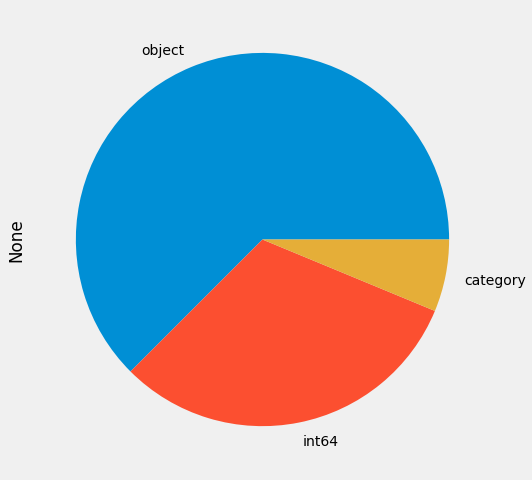

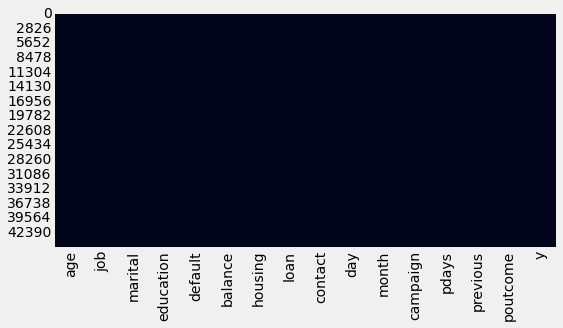

           pourcentage vals manquantes
age                                0.0
job                                0.0
marital                            0.0
education                          0.0
default                            0.0
balance                            0.0
housing                            0.0
loan                               0.0
contact                            0.0
day                                0.0
month                              0.0
campaign                           0.0
pdays                              0.0
previous                           0.0
poutcome                           0.0
y                                  0.0


In [102]:
df.overview()

On voit qu'il n'y a pas de valeurs nulles ce qui facilitera l'implémentation des modèles par la suite. On a des variables de type int64, des Object et de type category.

### 1.1 Etude de la variable cible

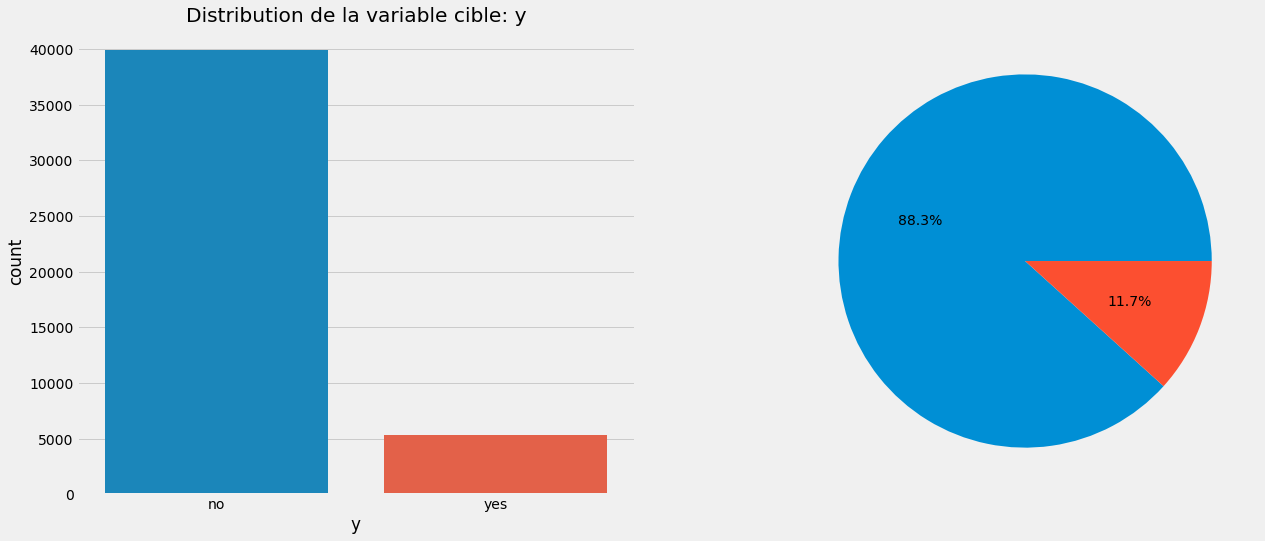

In [8]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(right=1.5)
plt.subplot(121)
sns.countplot(x='y', data=df.df)
plt.title("Distribution de la variable cible: y")
plt.subplot(122)
plt.pie(df.df['y'].value_counts(), autopct='%1.1f%%')
plt.show()

 On voit que la variable cible (y) qui représente la souscription ou non au deposit est très déséquilibrée. Il faudra le prendre en compte lors de l'implémentation des modèles.

### 1.2 Variables quantitatives

Matrice de Correlation de variables Numeriques


Distribution des variables numeriques


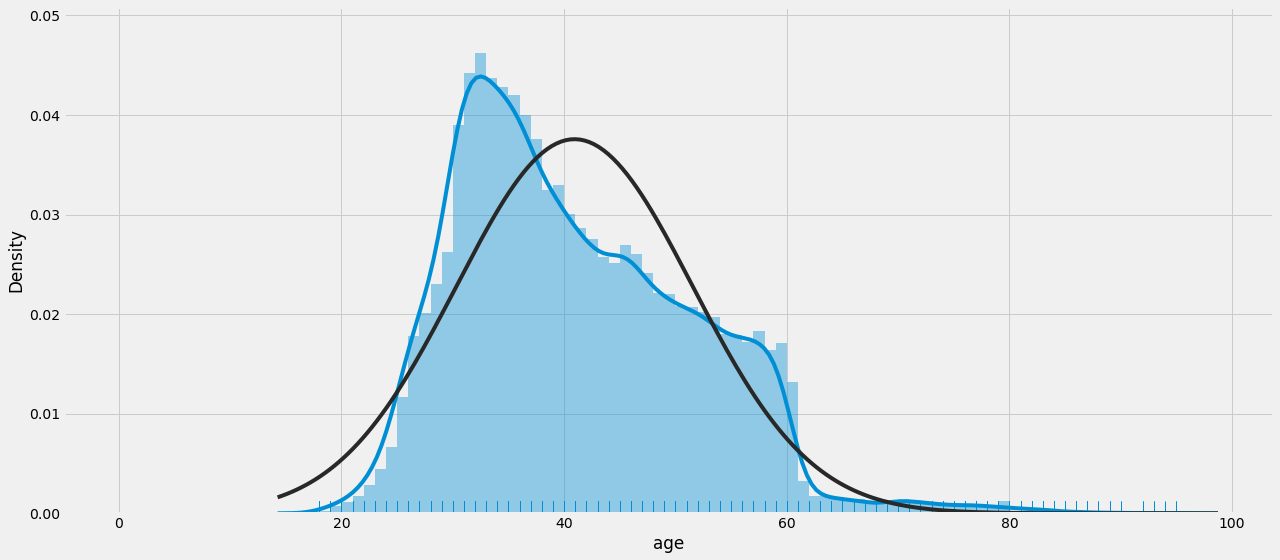

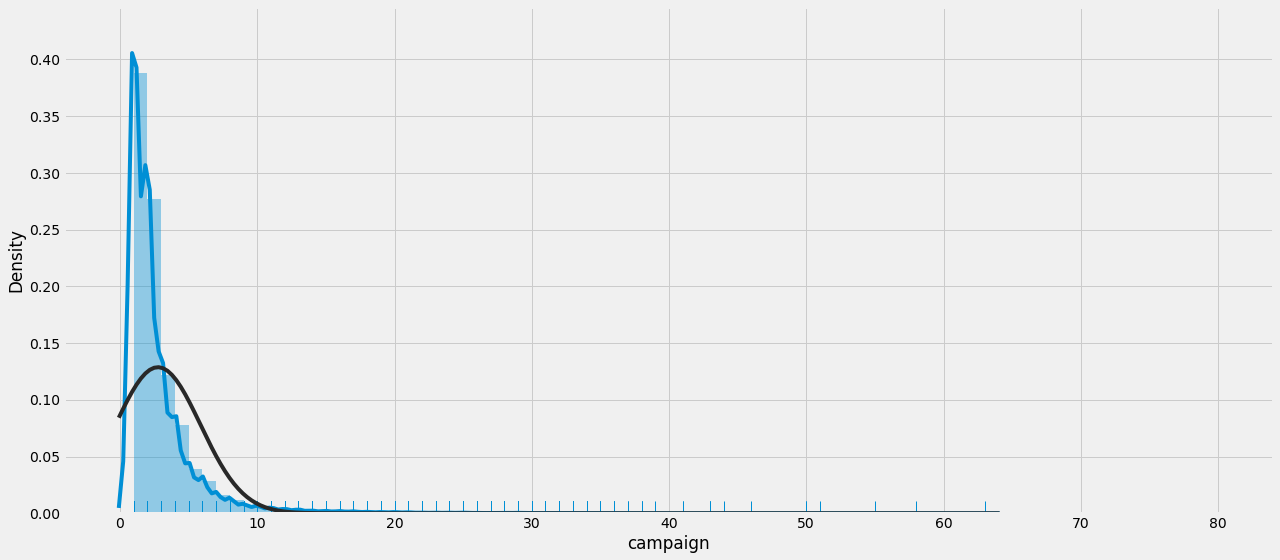

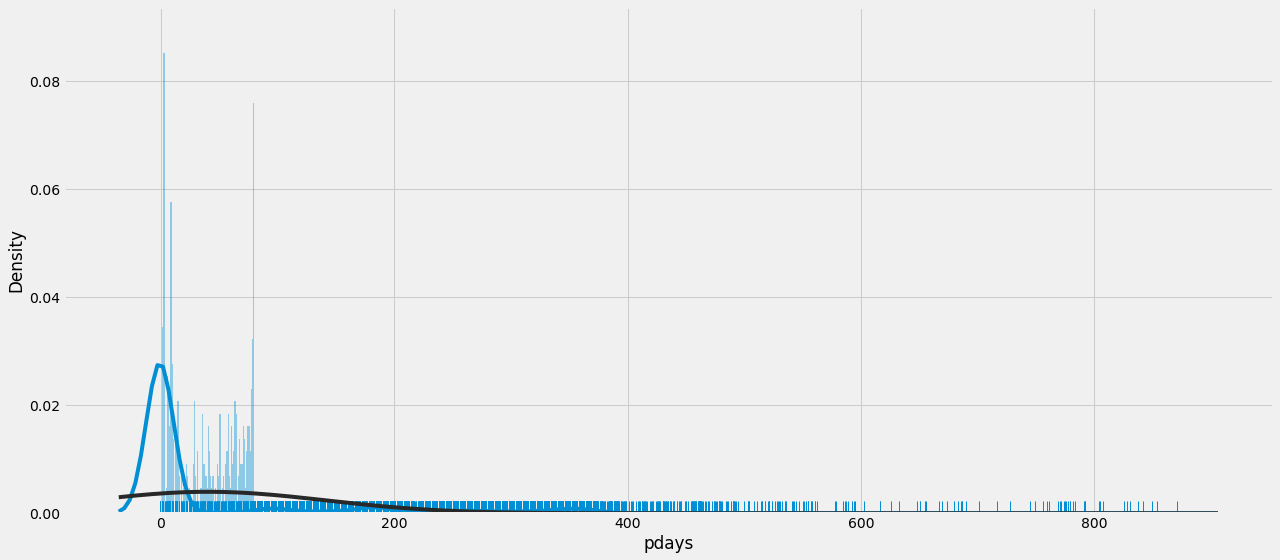

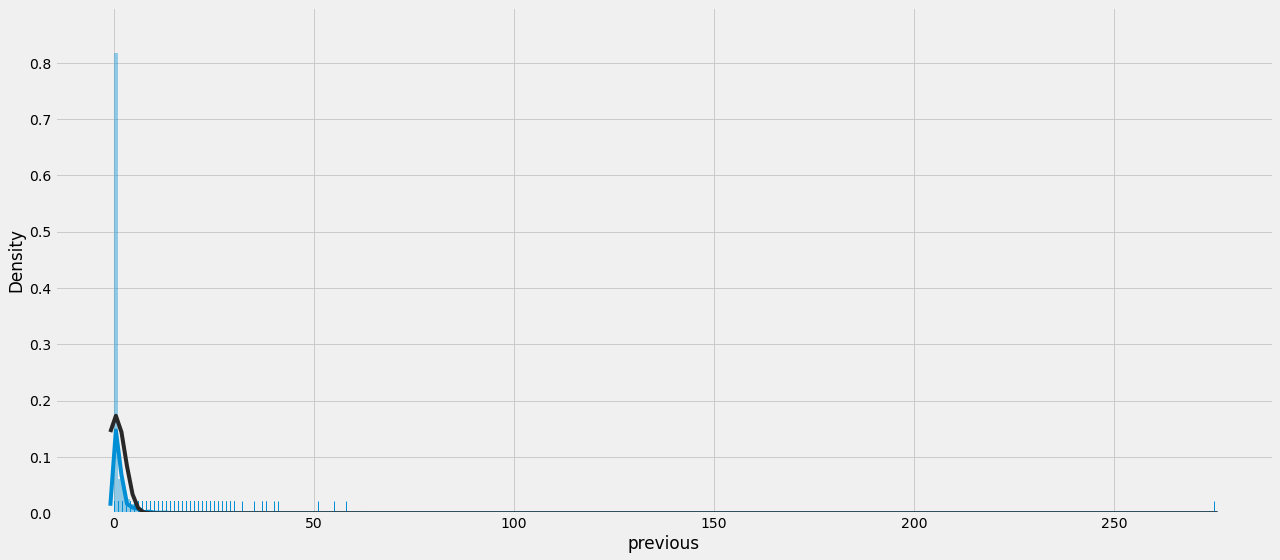

In [9]:
df.contFeatureOverview()

Il y a plusieurs features de type int ou float qui sont en fait catégorielles et n'entrent donc pas dans l'analyse de cette fonction. Le feature duration affecte énormément la variable cible (en effet si duration=0 alors forcément y="no") parce que le client n'a pas été contacté. De plus, la durée n'est pas une donnée qui est connue à l'avance et la valeur de y est connue à l'issue de l'appel donc ce feature est utile pour faire un benchmark et non prise en compte si l'objectif est d'avoir un modèle réaliste. Pdays affecte aussi énormement le model parce que -1 indique que le client n'à pas été contacté à nouveau.

In [10]:
df.df["pdays"].describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

Comme on peut le voir, le pdays contient énormément de valeurs -1 ce qui rend l'utilisation de ce feature compliqué et potentiellement biaisée.

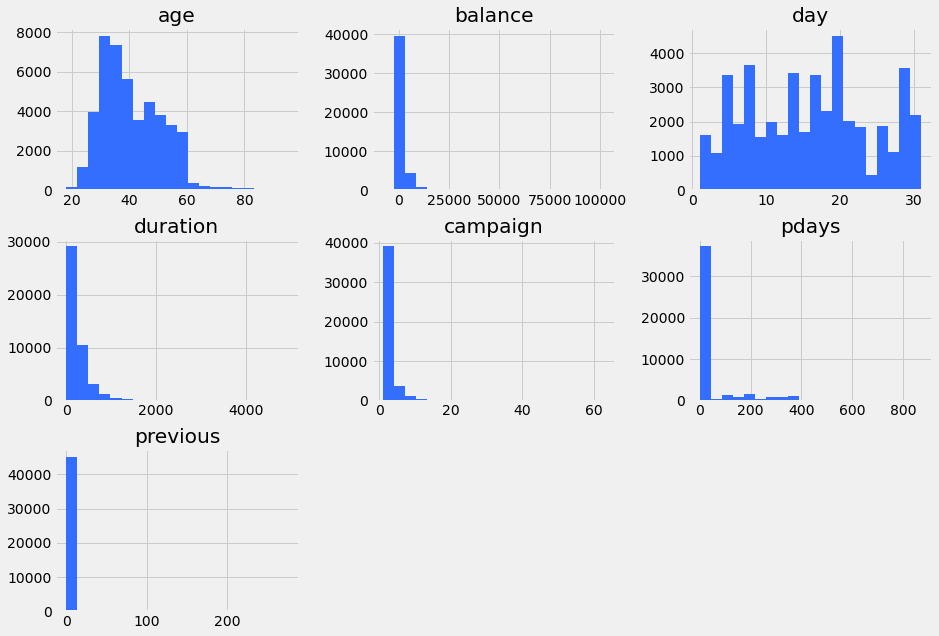

In [12]:
df.df.hist(bins=20, figsize=(14,10), color='#336eff')
plt.show()

 La variable age est assez assymétrique et la popluation à l'air assez jeune (la 30 aine). On remarque qu'il y a quelques valeurs aberrantes et une médiane a 39 ans. Certains features tels que campaign ou prévious ont énormément de valeurs nulles ou très faibles ce qui aura certainement des implications lors des traitements.

### 1.3 Variables catégorielles

In [13]:
for feature in df.catFeatures:
    print(df.df[feature].describe())

count           45211
unique             12
top       blue-collar
freq             9732
Name: job, dtype: object
count       45211
unique          3
top       married
freq        27214
Name: marital, dtype: object
count         45211
unique            4
top       secondary
freq          23202
Name: education, dtype: object
count     45211
unique        2
top          no
freq      44396
Name: default, dtype: object
count     45211
unique        2
top         yes
freq      25130
Name: housing, dtype: object
count     45211
unique        2
top          no
freq      37967
Name: loan, dtype: object
count        45211
unique           3
top       cellular
freq         29285
Name: contact, dtype: object
count     45211
unique       12
top         may
freq      13766
Name: month, dtype: object
count       45211
unique          4
top       unknown
freq        36959
Name: poutcome, dtype: object
count     45211
unique        2
top          no
freq      39922
Name: y, dtype: object


job--------------------------- ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']


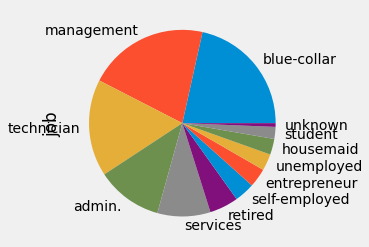

marital----------------------- ['married' 'single' 'divorced']


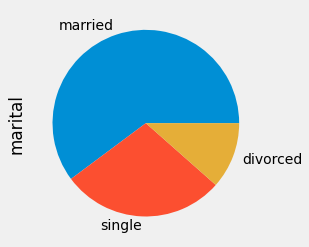

education--------------------- ['tertiary' 'secondary' 'unknown' 'primary']


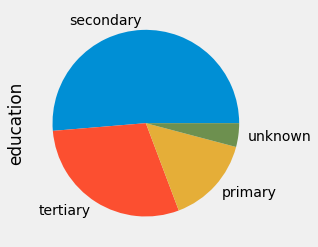

default----------------------- ['no' 'yes']


housing----------------------- ['yes' 'no']


loan-------------------------- ['no' 'yes']


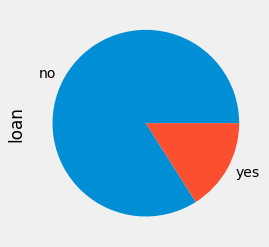

contact----------------------- ['unknown' 'cellular' 'telephone']


month------------------------- ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


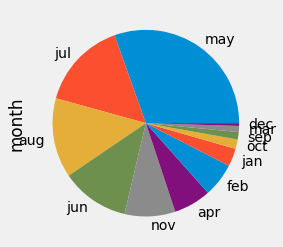

poutcome---------------------- ['unknown' 'failure' 'other' 'success']


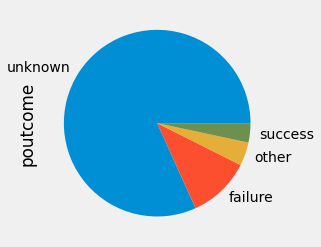

y----------------------------- ['no' 'yes']


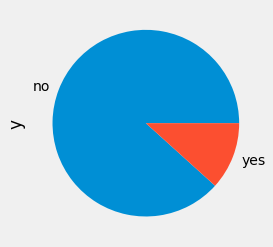

In [14]:
df.catFeatureOverview()

Il y a plusieurs features catégorielles dans lesquelles il manque des valeurs qui sont toutes encodées avec "unknown". Il faudra prendre en compte cette information en les traitant avec des imputations notamment. Certaines telles que "month" possèdent énormément de catégories ce qui peut compliquer l'implémentation des algorithmes.

### 1.4 Variables catégorielles avec la variable cible

In [17]:
df.relationBivCat('job')

Globalement, les proportions semblent similaires quels que soient le travail des gens qui on été sondés, néanmoins certaines catégories d'emplois sont sur représentés comme le management ou blue-collar contrairement à d'autres très sous-représentés comme les étudiants ou les sans emplois.

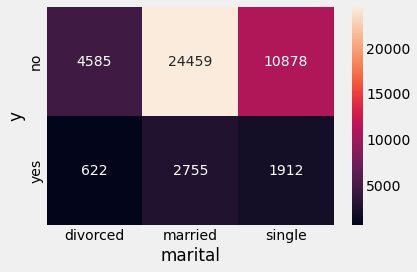

In [103]:
df.relationBivCat('marital')

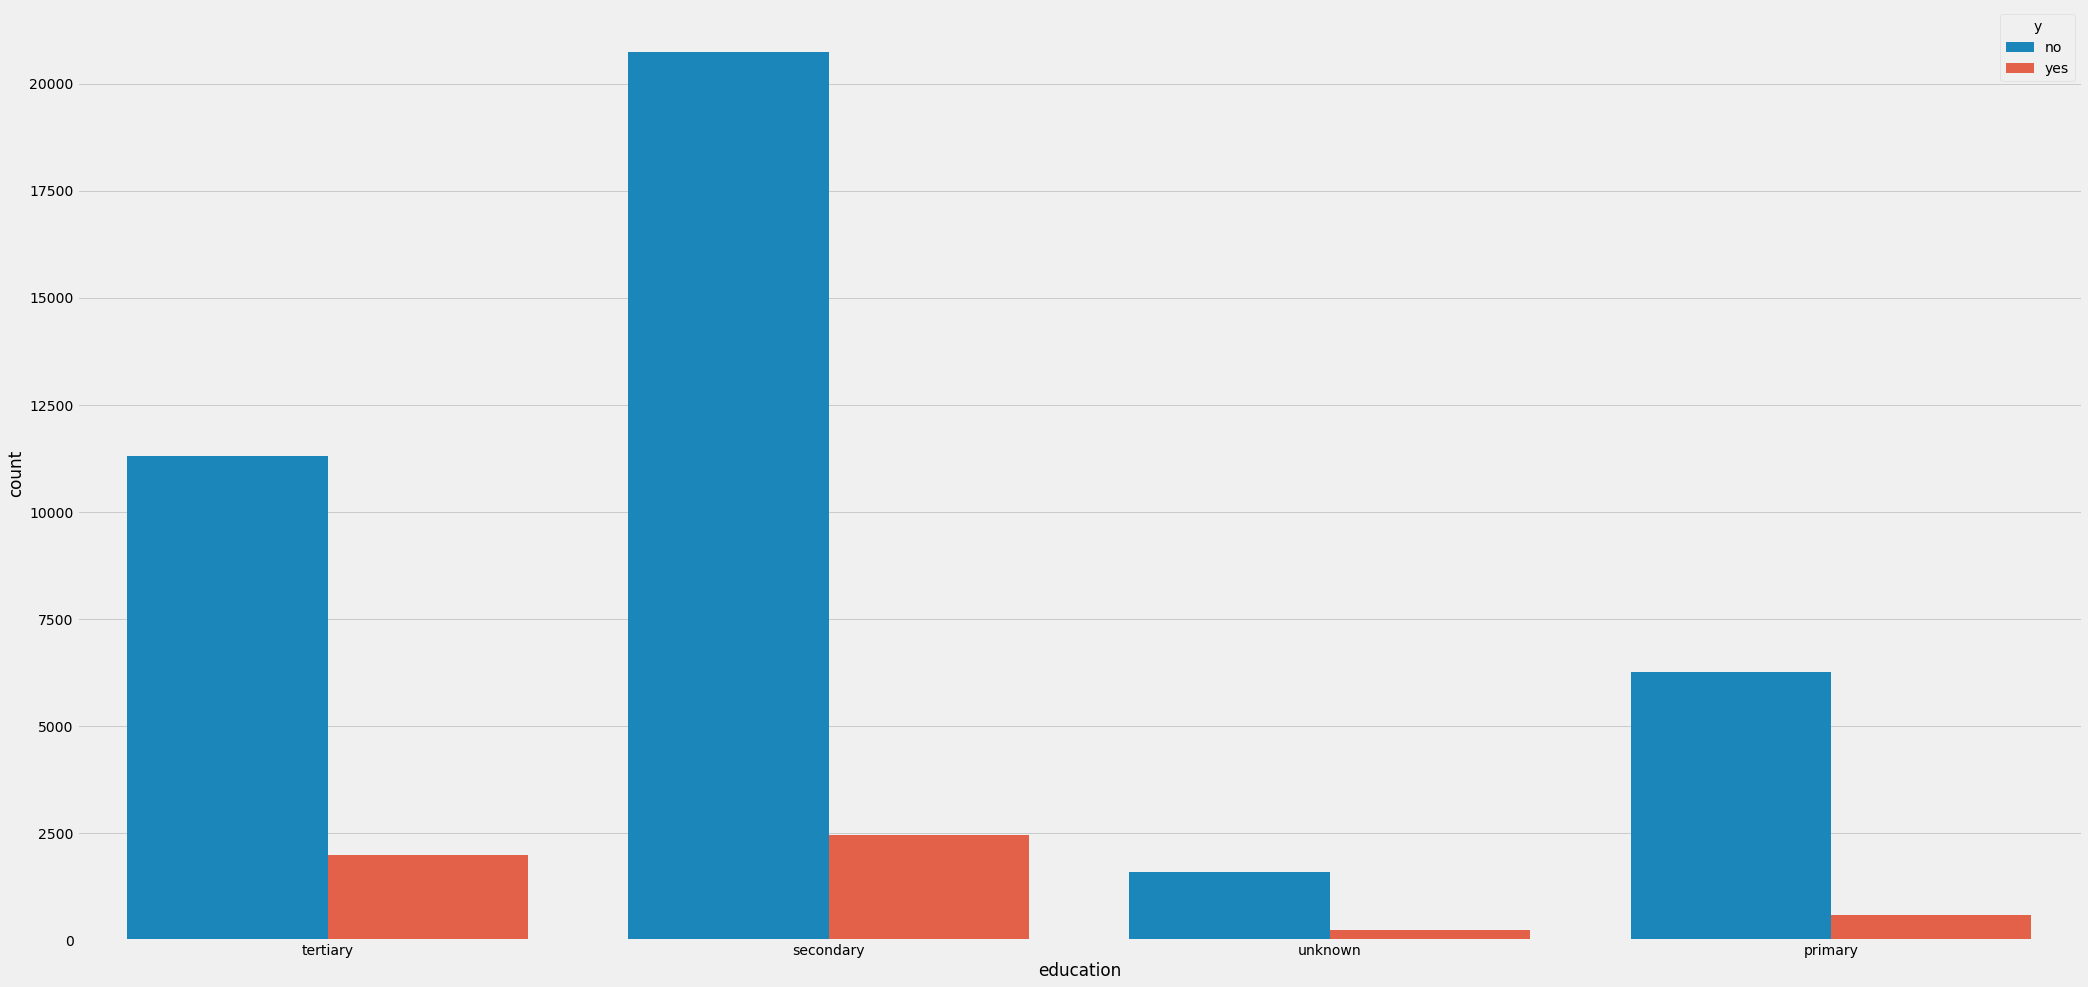

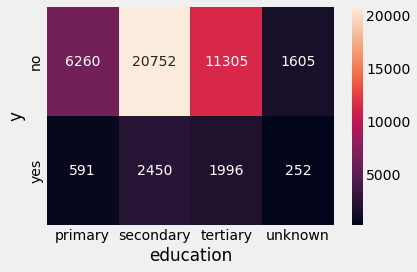

In [104]:
df.relationBivCat('education')

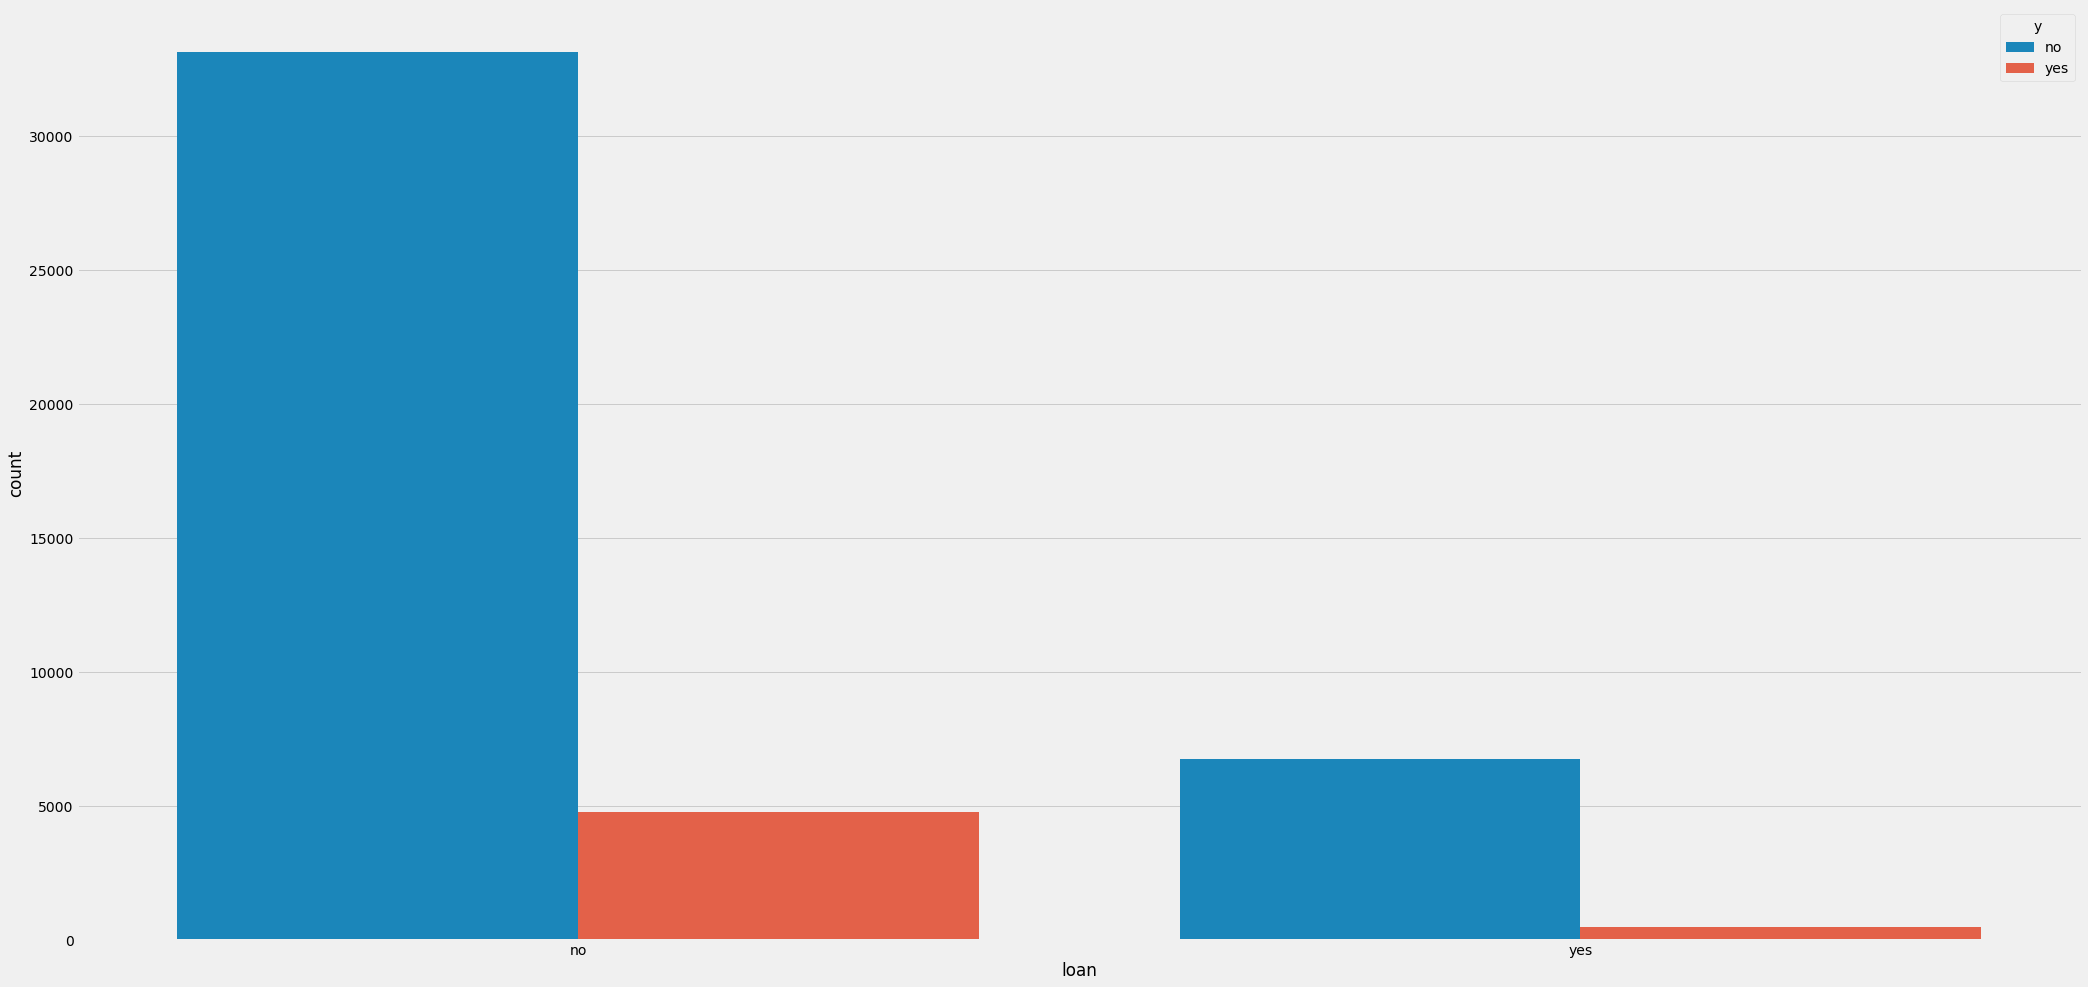

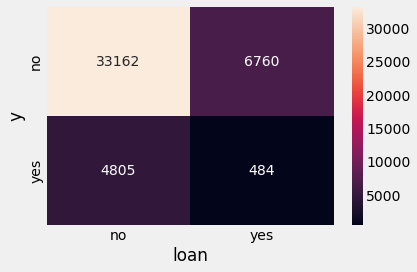

In [105]:
df.relationBivCat('loan')

In [112]:
### 1.5 Variables continues avec la variable cible

In [111]:
sns.boxplot(x = 'duration', y = 'y', data=df.df);

On voit que dans l'ensemble, les clients qui ont créé un compte de dépôt ont une durée d'appel plus élevée que ceux qui n'en ont pas créé. Le temps passé au téléphone pourrait donc impliqué que le client se laisse plus convaincre.

In [16]:
sns.boxplot(x = 'age', y = 'y', data=df.df);

Il y a peu de différences d'age entre ceux qui ont créé un compte de dépôt ou non.

In [17]:
sns.boxplot(x = 'y', y = 'age', hue='marital', data=df.df);

La moyenne d'age est plus faible parmi la population qui est single que celle mariée (ce qui parait logique) mais dans l'ensemble il n'y a pas de grosse influence de l'age dans le statut marital sur la création de compte de dépôt ou non.

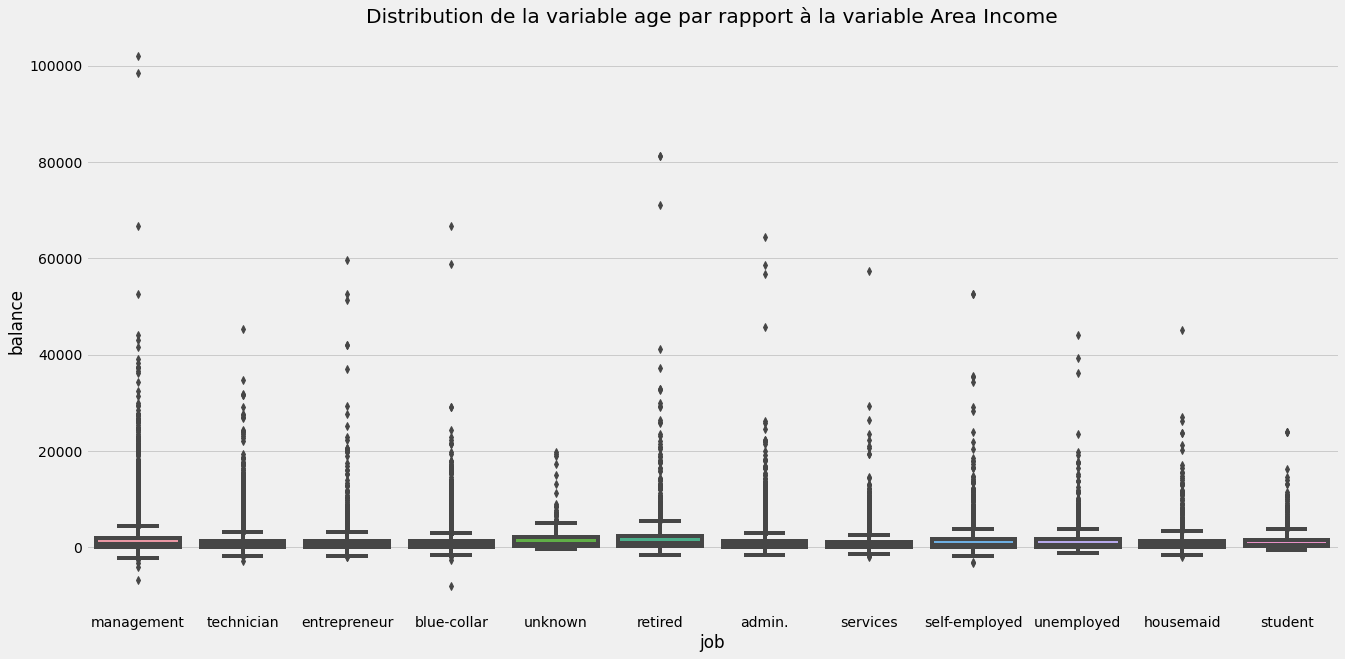

In [107]:
plt.figure(figsize=(20,10))
sns.boxplot(x='job', y='balance', data=df.df)
plt.title("Distribution de la variable x par rapport à la variable y")
plt.show()

## 2 Implémentation des divers modèles

### 2.1 Dummy Classifier

In [18]:
from sklearn.dummy import DummyClassifier
clf_dummy = DummyClassifier(random_state=RANDOM_STATE)

In [123]:
df.separateDataset()
df.setupTrainingVariables()
clf_dummy.fit(df.X_train, df.y_train)

DummyClassifier(random_state=0)

In [20]:
clf_dummy.score(df.X_test, df.y_test)

0.8824505142098861

On voit que le score d'un dummy classifier est très bon ce qui est pas étonnant étant donné que les données sont très désiquilibrées donc forcément, il a de grande chance d'avoir de bons résultats sur la classe majoritaire mais pas dans la classe minoritaire.

### 2.2 Arbre par defaut sans Pre Processing

In [214]:
#Preparation de dataset avec seulement encodage de variables
df.separateDataset()
df.encodeAll()
df.setupTrainingVariables()

Matrice de confusion:
[[7331  649]
 [ 556  507]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      7980
           1       0.44      0.48      0.46      1063

    accuracy                           0.87      9043
   macro avg       0.68      0.70      0.69      9043
weighted avg       0.87      0.87      0.87      9043
 

Exactitude: 86.674776 



Learning Curve


ROC SCORE: 0.6978118508878027


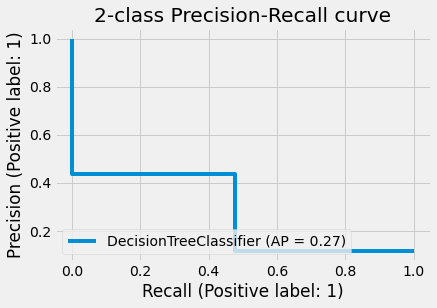

In [13]:
dec_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
df.evaluation(dec_tree)

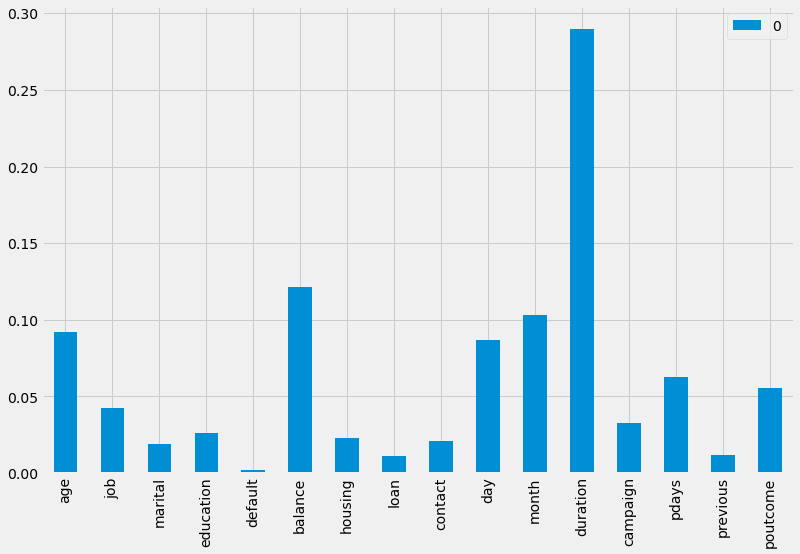

In [14]:
df1_important_features = pd.DataFrame(dec_tree.feature_importances_, index=df.X_train.columns)
df1_important_features.plot.bar(figsize=(12,8))
plt.show()

Le modèle apparait clairement en over-fitting et on remarque une fois de plus l'imporance de la variable "duration" dans le cas d'un arbre de décision.

### 2.3 Foret aleatoire sans preprocessing
Kbest

In [15]:
rand_for = make_pipeline(SelectKBest(f_classif, k=10), 
                     RandomForestClassifier(random_state=RANDOM_STATE))


Matrice de confusion:
[[7657  323]
 [ 675  388]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7980
           1       0.55      0.37      0.44      1063

    accuracy                           0.89      9043
   macro avg       0.73      0.66      0.69      9043
weighted avg       0.88      0.89      0.88      9043
 

Exactitude: 88.963839 



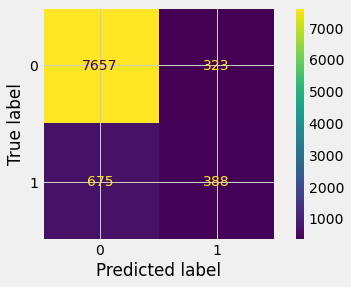

Learning Curve


ROC SCORE: 0.6622642565963357


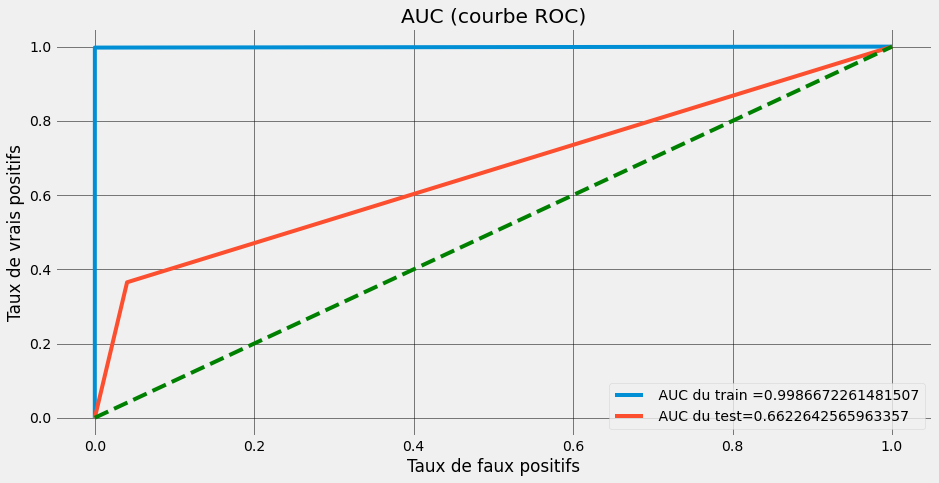

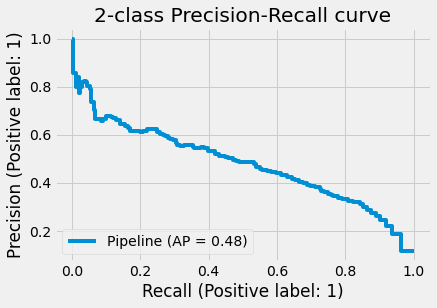

In [16]:
df.evaluation(rand_for)

### 2.4 Foret aleatoire sans preprocessing
kbest, polynomial features

Matrice de confusion:
[[7713  267]
 [ 662  401]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.60      0.38      0.46      1063

    accuracy                           0.90      9043
   macro avg       0.76      0.67      0.70      9043
weighted avg       0.88      0.90      0.89      9043
 

Exactitude: 89.726861 



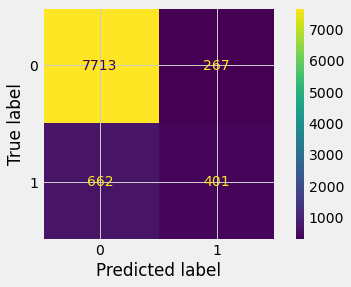

Learning Curve


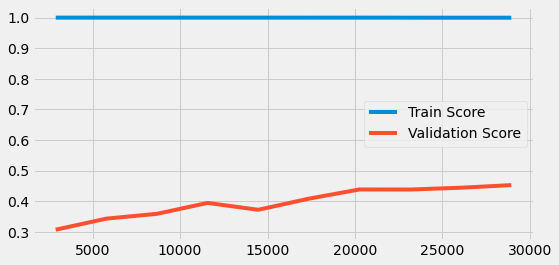

ROC SCORE: 0.6718877980463859


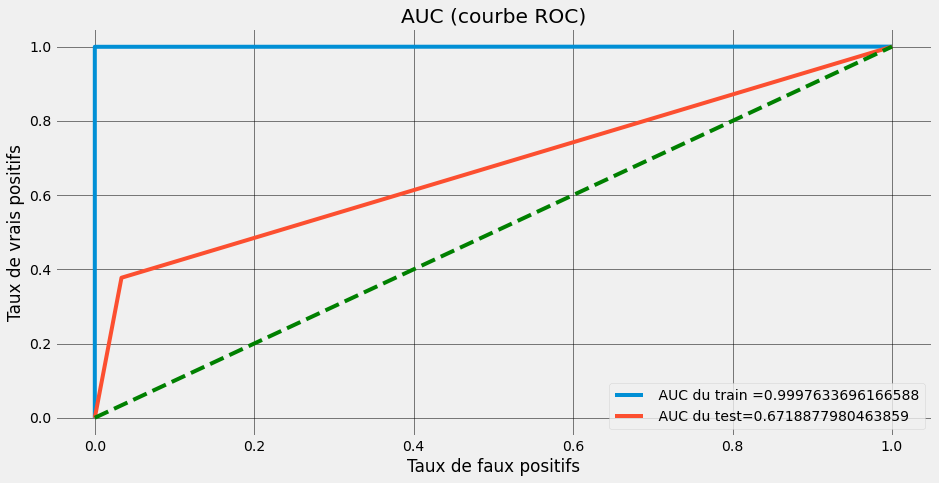

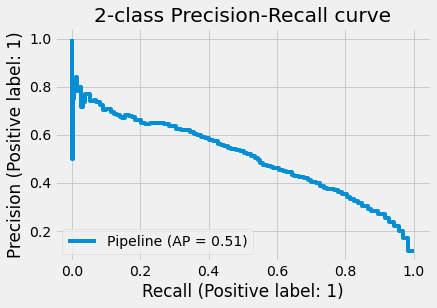

In [37]:
rand_forv2 = make_pipeline(PolynomialFeatures(2), 
                      SelectKBest(f_classif, k=10),
                     RandomForestClassifier(random_state=RANDOM_STATE))
df.evaluation(rand_forv2)

### 2.5 Adaboost sans preprocessing

Matrice de confusion:
[[7695  285]
 [ 681  382]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7980
           1       0.57      0.36      0.44      1063

    accuracy                           0.89      9043
   macro avg       0.75      0.66      0.69      9043
weighted avg       0.88      0.89      0.88      9043
 

Exactitude: 89.317704 



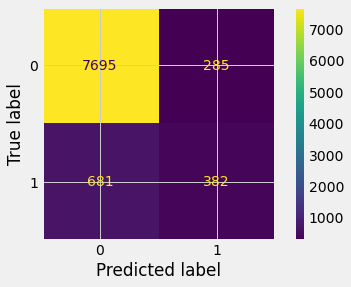

Learning Curve


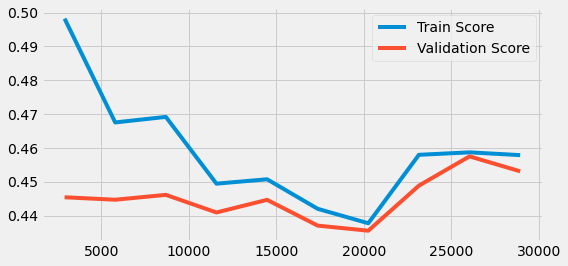

ROC SCORE: 0.6618230076602607


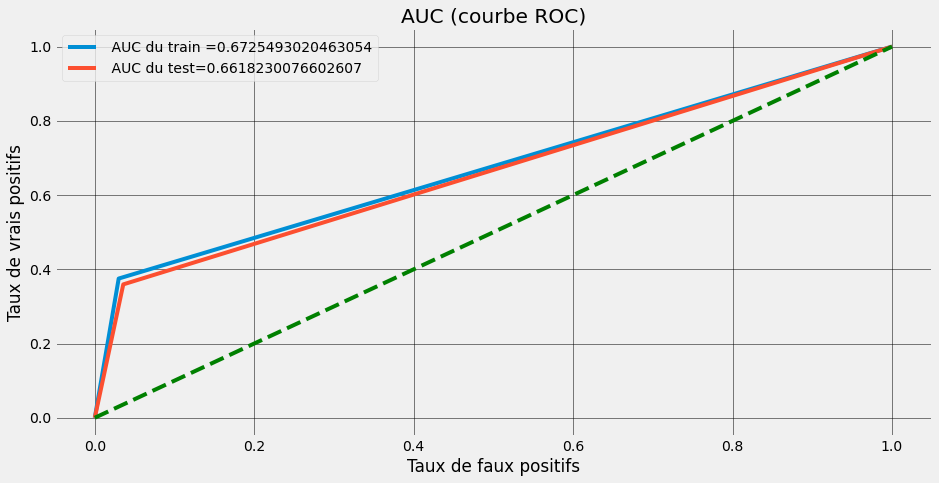

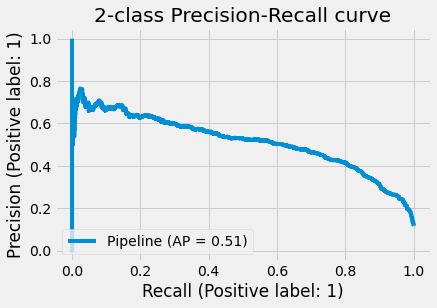

In [41]:
AdaBoost = make_pipeline(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0))
df.evaluation(AdaBoost)

### 2.6 Regression logistiques

In [223]:
df = dataset('bank.csv', 'y')
df.separateDataset()
#df.normaliseCont()
df.encodeAll()
df.setupTrainingVariables()

Répertoire du dataset train: data\bank.csv


In [230]:
clf_logreg = make_pipeline(StandardScaler(), LogisticRegression(penalty='none', random_state=RANDOM_STATE))
clf_logregRidge = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=RANDOM_STATE)) # (penalty='l2') par défaut
clf_logregLasso = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE))
clf_logregElasticNet = make_pipeline(StandardScaler(), LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=RANDOM_STATE))

Matrice de confusion:
[[7799  181]
 [ 832  231]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7980
           1       0.56      0.22      0.31      1063

    accuracy                           0.89      9043
   macro avg       0.73      0.60      0.63      9043
weighted avg       0.86      0.89      0.87      9043
 

Exactitude: 88.797965 



Learning Curve


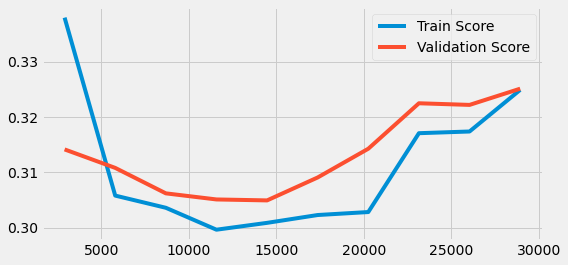

ROC SCORE: 0.5973138985752244


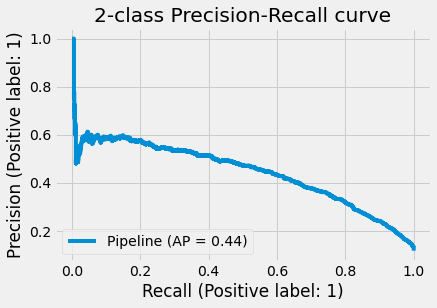

In [231]:
df.evaluation(clf_logreg)

Matrice de confusion:
[[7843  137]
 [ 899  164]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7980
           1       0.54      0.15      0.24      1063

    accuracy                           0.89      9043
   macro avg       0.72      0.57      0.59      9043
weighted avg       0.86      0.89      0.86      9043
 

Exactitude: 88.543625 



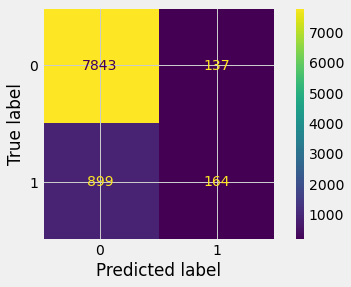

Learning Curve


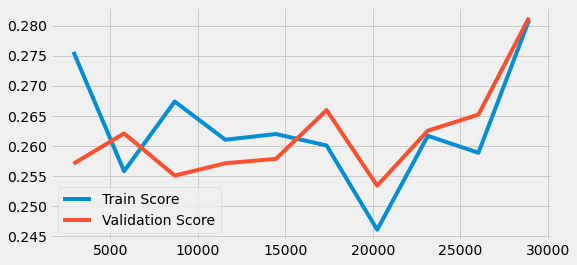

ROC SCORE: 0.5685562094323297


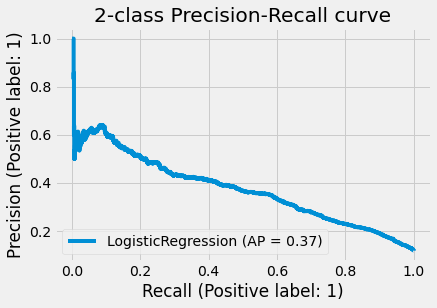

In [216]:
df.evaluation(clf_logregRidge)

Matrice de confusion:
[[7799  181]
 [ 833  230]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7980
           1       0.56      0.22      0.31      1063

    accuracy                           0.89      9043
   macro avg       0.73      0.60      0.63      9043
weighted avg       0.86      0.89      0.87      9043
 

Exactitude: 88.786907 



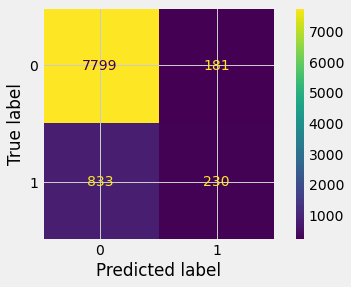

Learning Curve


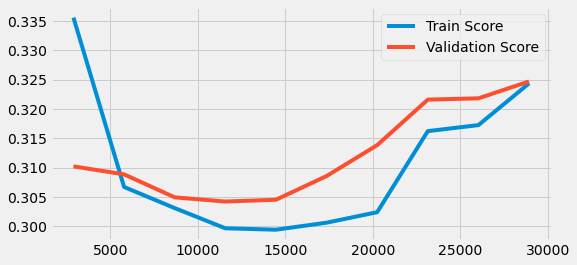

ROC SCORE: 0.5968435316890532


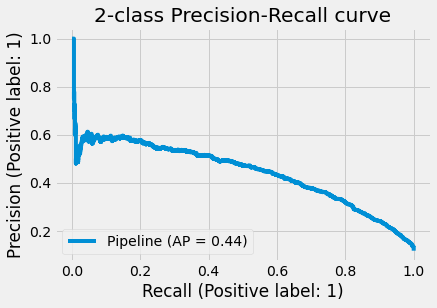

In [232]:
df.evaluation(clf_logregLasso)

Matrice de confusion:
[[7805  175]
 [ 838  225]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7980
           1       0.56      0.21      0.31      1063

    accuracy                           0.89      9043
   macro avg       0.73      0.59      0.62      9043
weighted avg       0.86      0.89      0.86      9043
 

Exactitude: 88.797965 



Learning Curve


ROC SCORE: 0.5948676371078213


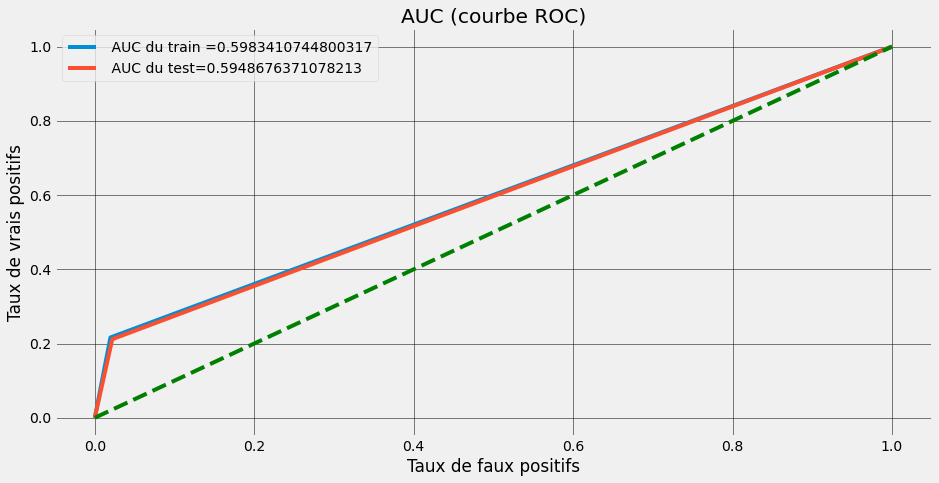

In [229]:
df.evaluation(clf_logregElasticNet)

In [221]:
df.X_train.head()

age  job  marital  education  default  balance  housing  loan  contact  \
13932   57    0        0          1        0      658        0     0        0   
9894    37    1        1          1        0     1699        0     0        0   
39946   35    9        0          1        0     2823        1     0        0   
9217    35    0        1          1        0      214        1     1        0   
4124    38    7        2          2        0      323        1     0        0   

       day  month  duration  campaign  pdays  previous  poutcome  
13932   10      5       724         1      1         0         3  
9894     9      6        63         1      1         0         3  
39946    2      6       102         4      0         2         0  
9217     5      6       247         1      1         0         3  
4124    19      8       138         1      1         0         3

## 3 Implémentation d'un preprocessing spécifique

In [218]:
df = dataset('bank.csv', 'y')
#Reload dataset class
#modification de pdays en categorielle puis encodage
df.df["pdays"] = pd.cut(x=df.df["pdays"], bins=[-2, 0, 871], labels=['noncontacted', 'contacted'])
df.addCatFeature("pdays")

Répertoire du dataset train: data\bank.csv


In [219]:
#df.Preprocess()
df.separateDataset()
df.imputeDataset()
#Pas besoin de normaliser les données
#df.normaliseCont()
df.encodeAll()
df.setupTrainingVariables()

In [233]:
df.X_train.head()

age  job  marital  education  default   balance  housing  loan  \
13932  1.515061    0        0          1        0 -0.231637        0     0   
9894  -0.369597   11        1          3        0  0.106038        0     0   
39946 -0.558063    9        0          1        0  0.470635        1     0   
9217  -0.558063    0        1          1        0 -0.375660        1     1   
4124  -0.275365    7        2          2        0 -0.340303        1     0   

       contact       day  month  duration  campaign     pdays  previous  \
13932        0 -0.698514      5  1.808943 -0.567836 -0.410222 -0.241405   
9894         2 -0.818717      6 -0.755580 -0.567836 -0.410222 -0.241405   
39946        0 -1.660136      6 -0.604270  0.402837  0.560728  0.585721   
9217         2 -1.299528      6 -0.041704 -0.567836 -0.410222 -0.241405   
4124         2  0.383311      8 -0.464598 -0.567836 -0.410222 -0.241405   

       poutcome  
13932         3  
9894          3  
39946         0  
9217          3  
4124          3

### 3.1 Arbre de décision avec preprocessing

Matrice de confusion:
[[7363  617]
 [ 578  485]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      7980
           1       0.44      0.46      0.45      1063

    accuracy                           0.87      9043
   macro avg       0.68      0.69      0.69      9043
weighted avg       0.87      0.87      0.87      9043
 

Exactitude: 86.785359 



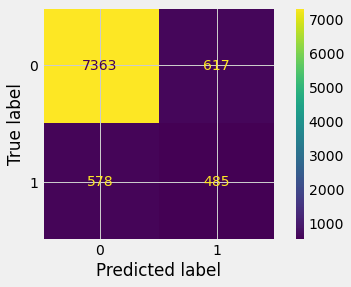

Learning Curve


ROC SCORE: 0.6894687919233644


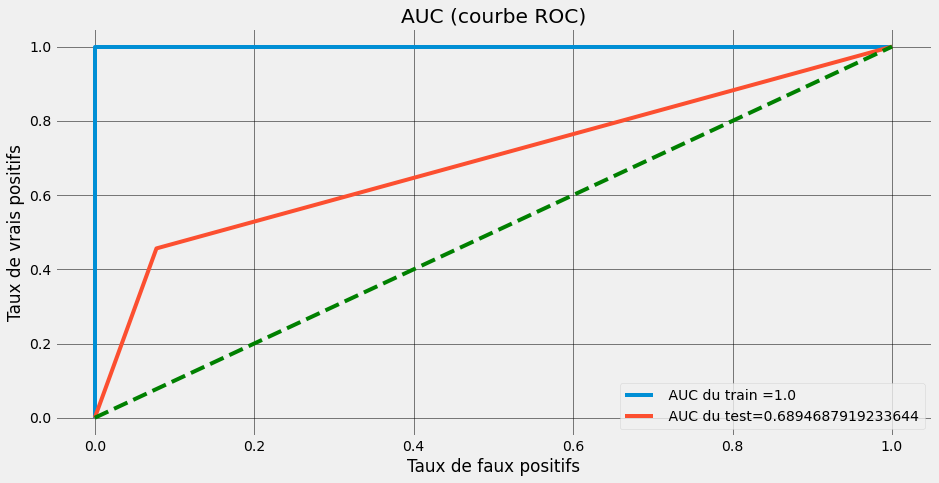

In [33]:
dec_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
df.evaluation(dec_tree)

### 3.2 RandomForest avec Preprocessing 

Matrice de confusion:
[[7690  290]
 [ 676  387]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7980
           1       0.57      0.36      0.44      1063

    accuracy                           0.89      9043
   macro avg       0.75      0.66      0.69      9043
weighted avg       0.88      0.89      0.88      9043
 

Exactitude: 89.317704 



Learning Curve


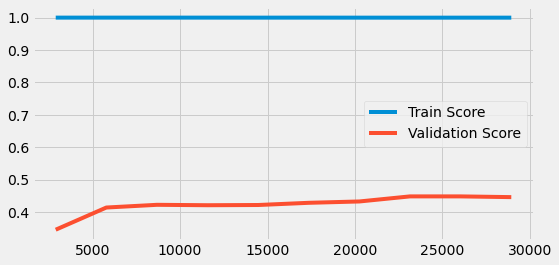

ROC SCORE: 0.6638615588830968


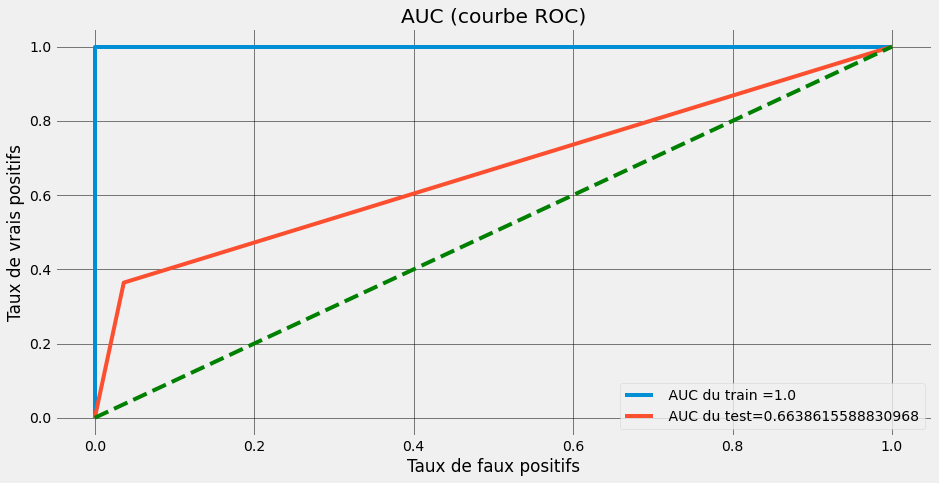

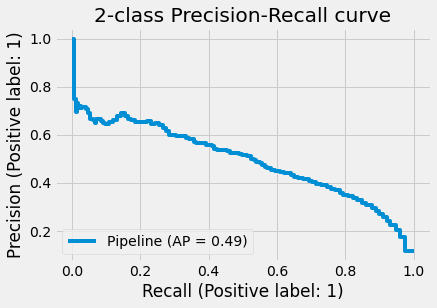

In [34]:
rand_forv2 = make_pipeline(PolynomialFeatures(2), 
                      SelectKBest(f_classif, k=10),
                     RandomForestClassifier(random_state=RANDOM_STATE))
df.evaluation(rand_forv2)

### 3.3 SVM avec Preprocessing

Matrice de confusion:
[[7788  192]
 [ 755  308]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7980
           1       0.62      0.29      0.39      1063

    accuracy                           0.90      9043
   macro avg       0.76      0.63      0.67      9043
weighted avg       0.88      0.90      0.88      9043
 

Exactitude: 89.527812 



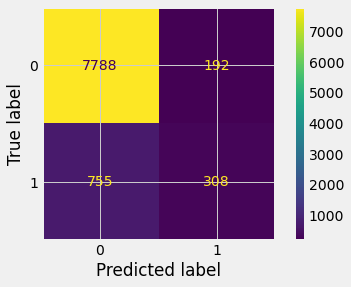

Learning Curve


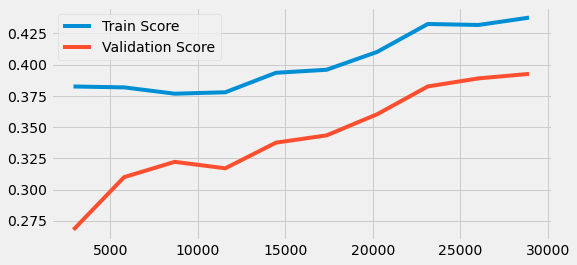

ROC SCORE: 0.6328429257527638


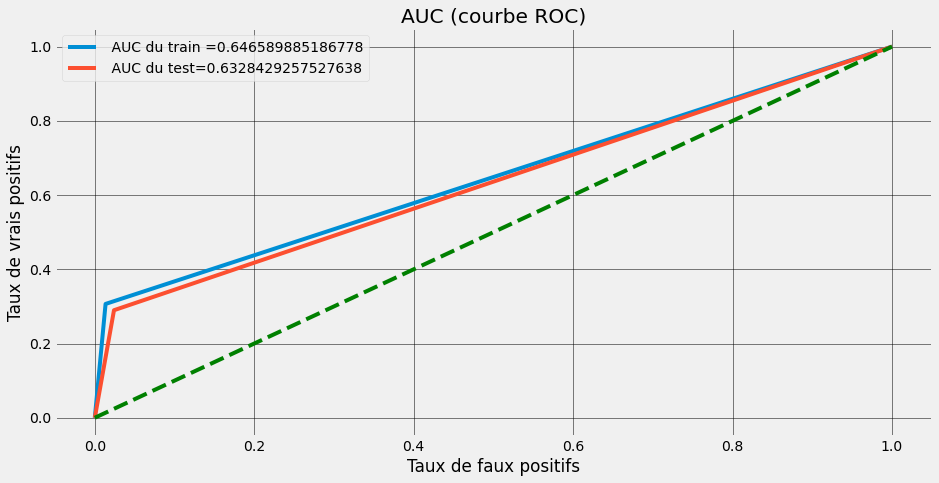

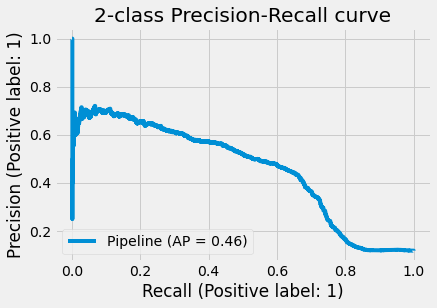

In [23]:
model_svm = make_pipeline(PolynomialFeatures(2, include_bias=False),
                      SelectKBest(f_classif, k=10),
                      StandardScaler(),
                      SVC(random_state=RANDOM_STATE))
df.evaluation(model_svm)

### 3.4 LinearSVC avec preprocessing

Matrice de confusion:
[[7874  106]
 [ 880  183]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7980
           1       0.63      0.17      0.27      1063

    accuracy                           0.89      9043
   macro avg       0.77      0.58      0.61      9043
weighted avg       0.87      0.89      0.86      9043
 

Exactitude: 89.096539 



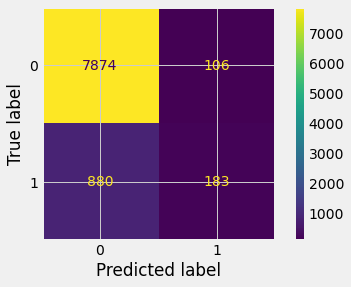

Learning Curve


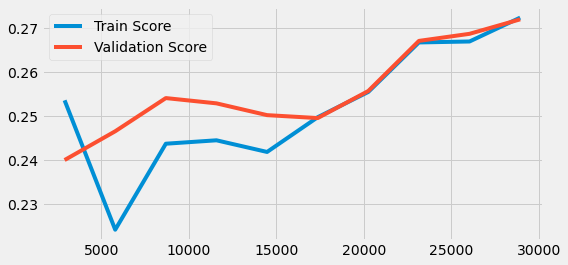

ROC SCORE: 0.5794355361593071


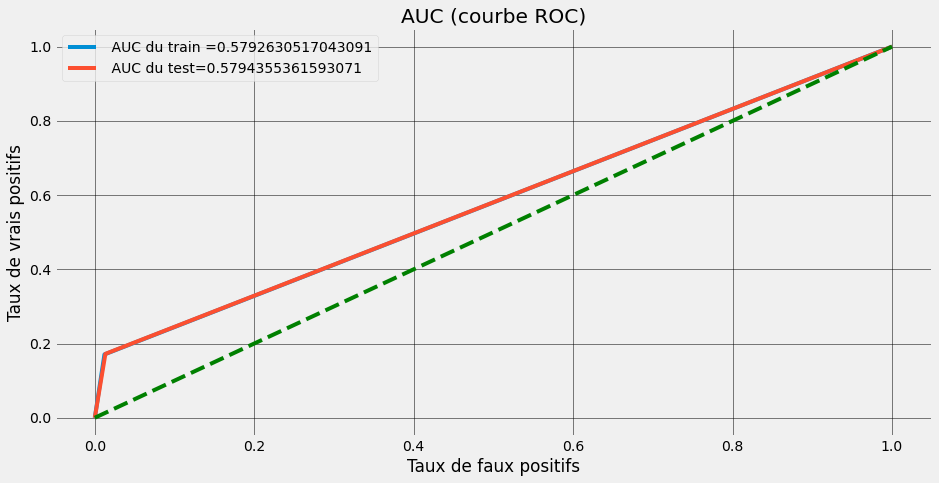

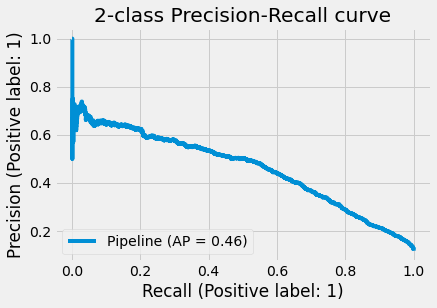

In [45]:
model_lsvm = make_pipeline(PolynomialFeatures(2, include_bias=False),
                      #SelectKBest(f_classif, k=14),
                      StandardScaler(),
                      LinearSVC(C=8e-2, random_state=RANDOM_STATE))
df.evaluation(model_lsvm)

### 3.5 AdaBoost

Matrice de confusion:
[[7695  285]
 [ 681  382]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7980
           1       0.57      0.36      0.44      1063

    accuracy                           0.89      9043
   macro avg       0.75      0.66      0.69      9043
weighted avg       0.88      0.89      0.88      9043
 

Exactitude: 89.317704 



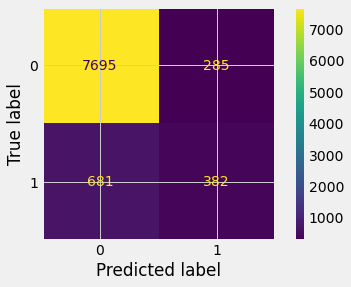

Learning Curve


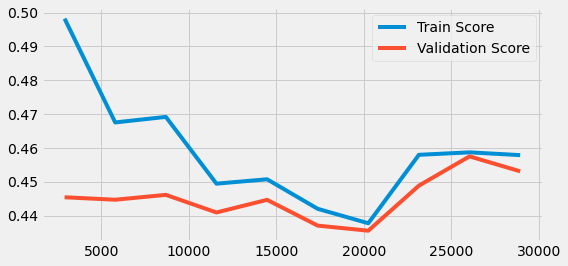

ROC SCORE: 0.6618230076602607


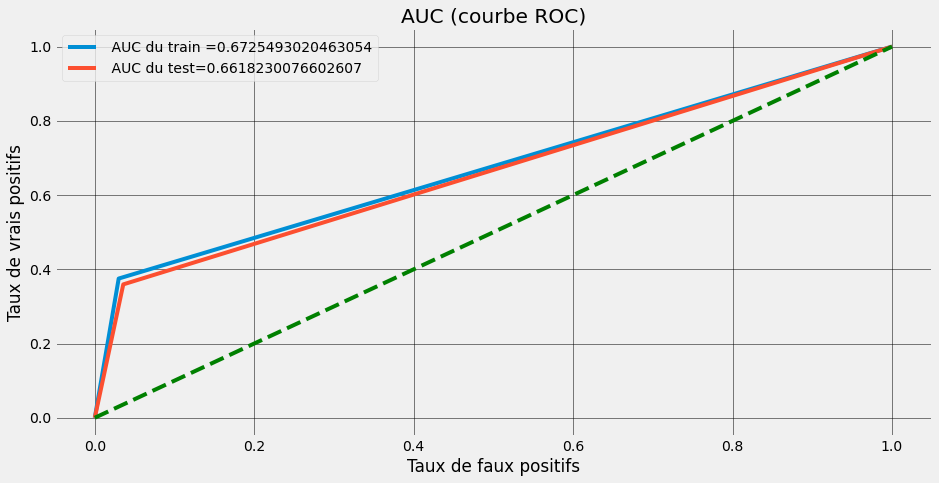

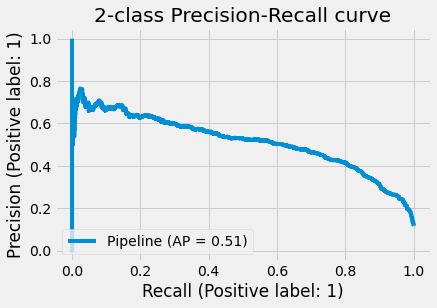

In [38]:
AdaBoost = make_pipeline(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0))
df.evaluation(AdaBoost)

## 4. Optimisation de quelques modeles
### 4.1 SVM

In [245]:
model_svm = make_pipeline(PolynomialFeatures(2, include_bias=False),
                      SelectKBest(f_classif, k=14),
                      StandardScaler(),
                      SVC(random_state=RANDOM_STATE))

In [66]:
hyper_params = {'svc__gamma':[1e-4, 1e-3], 
                'svc__C':[1, 10, 100, 1000]}
grid = GridSearchCV(estimator=model_svm, param_grid=hyper_params, cv=5, scoring='recall')

In [67]:
grid.fit(df.X_train, df.y_train)
print(grid.best_params_)
y_pred = grid.predict(df.X_test)
print(classification_report(df.y_test, y_pred)) # l'ordre est tres important sinon tous les calculs sont inversés
# dans la matrice de confusion

{'svc__C': 1000, 'svc__gamma': 0.001}
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7980
           1       0.64      0.24      0.34      1063

    accuracy                           0.89      9043
   macro avg       0.77      0.61      0.64      9043
weighted avg       0.87      0.89      0.87      9043



Matrice de confusion:
[[7838  142]
 [ 812  251]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7980
           1       0.64      0.24      0.34      1063

    accuracy                           0.89      9043
   macro avg       0.77      0.61      0.64      9043
weighted avg       0.87      0.89      0.87      9043
 

Exactitude: 89.450404 



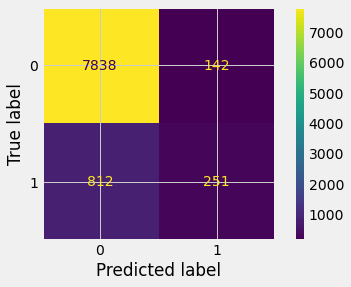

Learning Curve


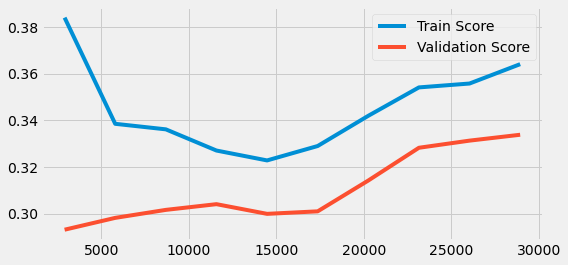

ROC SCORE: 0.6091648453212052


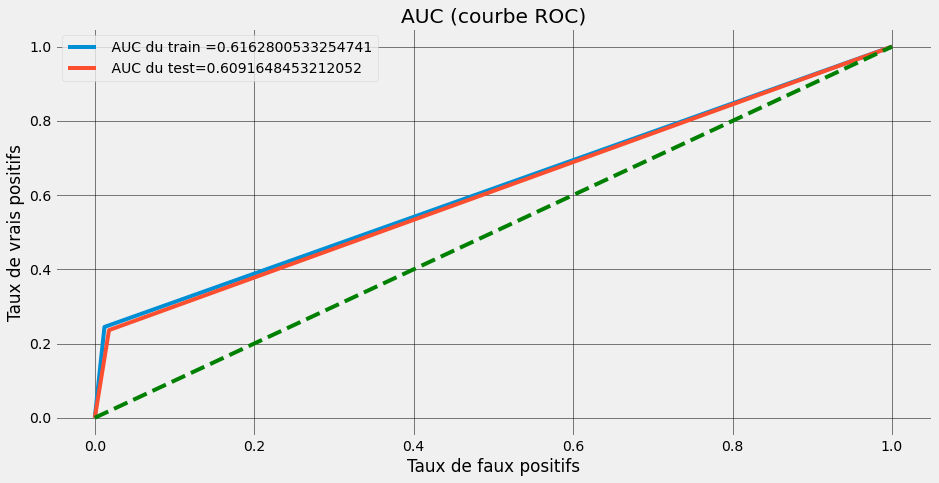

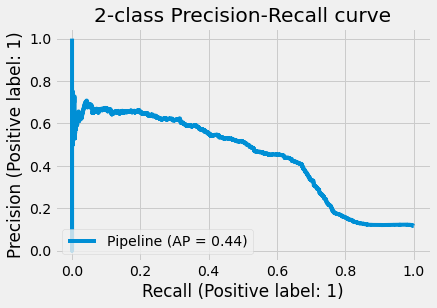

In [69]:
df.evaluation(grid.best_estimator_)

### 4.2 Adaboost optimisation

In [118]:
adahyper_params = {'adaboostclassifier__n_estimators':[60, 100], 
                'adaboostclassifier__learning_rate':[1e-1, 1]} # attention ne mettre pas d'espace

In [119]:
grid = GridSearchCV(AdaBoost, adahyper_params, scoring='recall', cv=5)

In [76]:
grid.fit(df.X_train, df.y_train)
print(grid.best_params_)
y_pred = grid.predict(df.X_test)
print(classification_report(df.y_test, y_pred)) # l'ordre est tres important sinon tous les calculs sont inversés
# dans la matrice de confusion 

{'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.59      0.37      0.46      1063

    accuracy                           0.90      9043
   macro avg       0.76      0.67      0.70      9043
weighted avg       0.88      0.90      0.89      9043



Matrice de confusion:
[[7709  271]
 [ 670  393]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.59      0.37      0.46      1063

    accuracy                           0.90      9043
   macro avg       0.76      0.67      0.70      9043
weighted avg       0.88      0.90      0.89      9043
 

Exactitude: 89.594161 



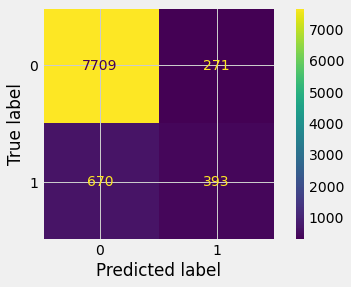

Learning Curve


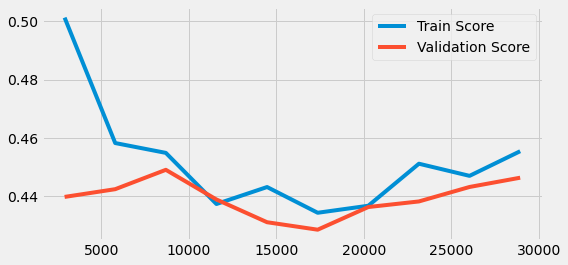

ROC SCORE: 0.6678742363906003


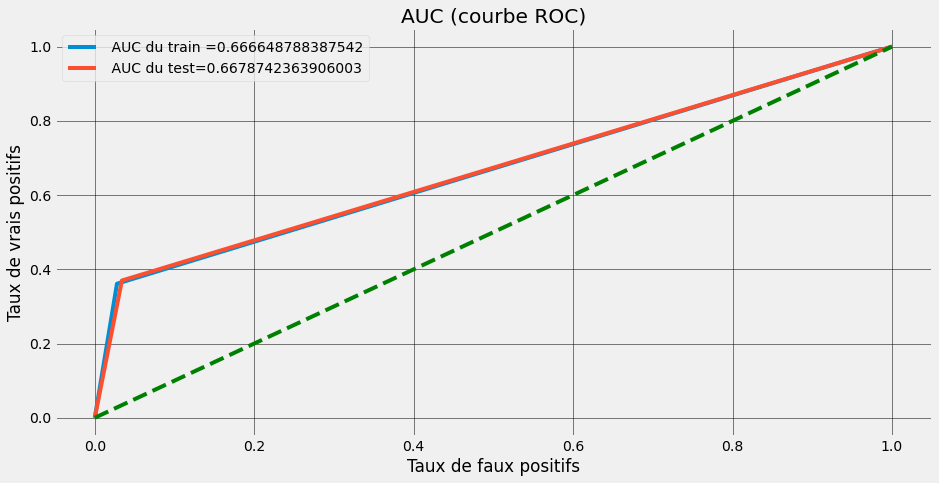

In [77]:
df.evaluation(grid.best_estimator_)

### 4.3 PCA reduction de dimension

In [78]:
def anomaly_scores(x_original, x_reduced):
    loss = np.sum((np.array(x_original) - np.array(x_reduced))**2, axis=1)
    loss = pd.Series(data=loss, index=x_original.index)
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss)) # loss entre 0. et 1.
    return loss

In [ ]:
#Ne marche pas - skip

In [19]:
n_components = 14
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)

In [21]:
X_train_pca = pca.fit_transform(df.X_train)
X_train_pca = pd.DataFrame(data=X_train_pca, index=df.X_train.index)

In [22]:
X_train_pca.shape
#Ne marche pas

(36168, 14)

### 4.4 Adaboost avec onehotencoding

In [237]:
df = dataset('bank.csv', 'y')
#Reload dataset class
#modification de pdays en categorielle puis encodage
#df.df["pdays"] = pd.cut(x=df.df["pdays"], bins=[-2, 0, 871], labels=['noncontacted', 'contacted'])
#df.dropColumn('duration')
#df.dropColumn('pdays')
df.refreshVariables()
df.separateDataset()
df.imputeDataset()
#Pas besoin de normaliser les données
#df.normaliseCont()
df.encodeAll(2)
#labelencoder ne marche pas avec pdays pour quelque raison....
#df.encodeCatFeature("pdays")
df.setupTrainingVariables()

Répertoire du dataset train: data\bank.csv


In [205]:
df.y_train.head()

13932    1
9894     0
39946    0
9217     0
4124     0
Name: y, dtype: int32

In [238]:
grid = GridSearchCV(AdaBoost, adahyper_params, scoring='recall', cv=5)
grid.fit(df.X_train, df.y_train)
print(grid.best_params_)
y_pred = grid.predict(df.X_test)
print(classification_report(df.y_test, y_pred)) # l'ordre est tres important sinon tous les calculs sont inversés
# dans la matrice de confusion 

{'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 60}
              precision    recall  f1-score   support

         0.0       0.57      0.07      0.13      1063
         1.0       0.89      0.99      0.94      7980

    accuracy                           0.88      9043
   macro avg       0.73      0.53      0.53      9043
weighted avg       0.85      0.88      0.84      9043



Matrice de confusion:
[[  77  986]
 [  58 7922]] 

Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.57      0.07      0.13      1063
         1.0       0.89      0.99      0.94      7980

    accuracy                           0.88      9043
   macro avg       0.73      0.53      0.53      9043
weighted avg       0.85      0.88      0.84      9043
 

Exactitude: 88.455159 



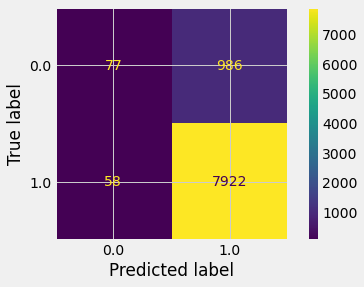

Learning Curve


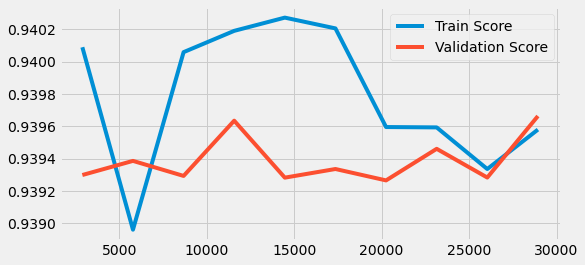

ROC SCORE: 0.5325841650221508


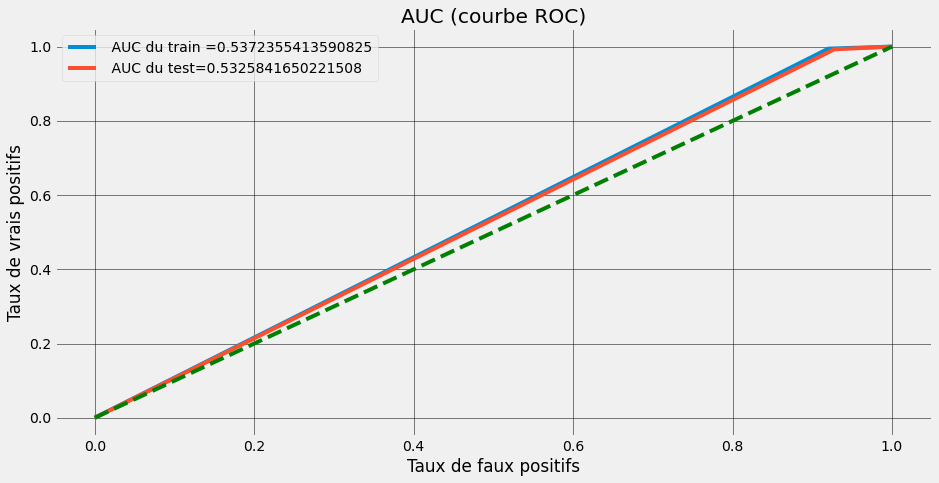

In [239]:
df.evaluation(grid.best_estimator_)

Ici on retrouve quelque chose interessant lorsqu'on utilise un onehot encoder. Nos valeurs de la variable cible sont encodés de facon inverse avec 'non' comment 1 et 'oui' comment 0. Ce qui nous donne un modele qui essai de predire plus correctement les cas ou le client n'a pas choisi de souscrire.

## 5. Optimisation Adaboost Sans preprocessing

In [246]:
df = dataset('bank.csv', 'y')
#Reload dataset class
df.refreshVariables()
df.separateDataset()
df.encodeAll()
df.setupTrainingVariables()

Répertoire du dataset train: data\bank.csv


In [241]:
grid = GridSearchCV(AdaBoost, adahyper_params, scoring='recall', cv=5)
grid.fit(df.X_train, df.y_train)
print(grid.best_params_)
y_pred = grid.predict(df.X_test)
print(classification_report(df.y_test, y_pred)) # l'ordre est tres important sinon tous les calculs sont inversés
# dans la matrice de confusion 

{'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.60      0.37      0.46      1063

    accuracy                           0.90      9043
   macro avg       0.76      0.67      0.70      9043
weighted avg       0.88      0.90      0.89      9043



Matrice de confusion:
[[7724  256]
 [ 673  390]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7980
           1       0.60      0.37      0.46      1063

    accuracy                           0.90      9043
   macro avg       0.76      0.67      0.70      9043
weighted avg       0.88      0.90      0.89      9043
 

Exactitude: 89.726861 



Learning Curve


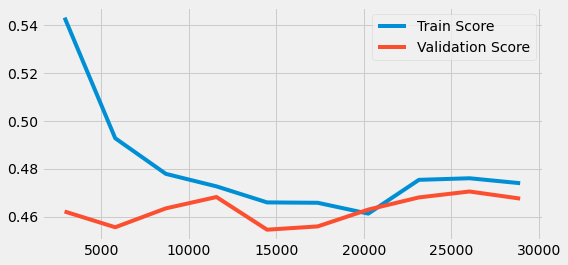

ROC SCORE: 0.6674029853561467


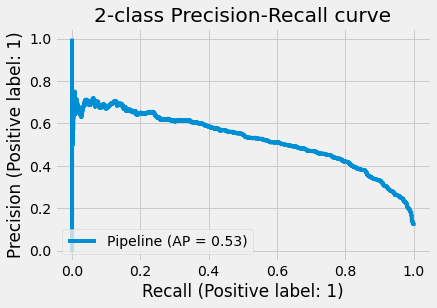

In [242]:
df.evaluation(grid.best_estimator_)

### Validation SVM

In [ ]:
list_hyperparams_svm = np.linspace(0.0001, 0.01, 30)
parameter = 'svc__C'
df.plotValidation(model_svm, parameter, list_hyperparams_svm)